# ECMs

This module contains different types of episodic and compositional memories (ECMs)

In [1]:
#| default_exp ECMs

In [2]:
#| hide
%load_ext autoreload
%autoreload 2

# ECMs constructors

Here we collect different standalone functions that will help us construct different types of ECM

## ECM updaters

In [3]:
#| export
def standard_ps_upd(reward, hmatrix, gmatrix, h_damp, g_damp):
    """
    Given a reward, updates h-matrix and g-matrix following the standard PS update rule:

    h <- h - h_damp*(h-1)+ reward*g
    g <- (1-g_damp)*g    
    """
    # damping h-matrix
    hmatrix = hmatrix - h_damp*(hmatrix-1.)
    # update h-matrix
    hmatrix += reward*gmatrix
    # update g-matrix
    gmatrix = (1-g_damp)*gmatrix

    return hmatrix, gmatrix

# Pre-built ECMs

Here we collect the abstract parent class that any ECM should be built upon as well as some pre-built ECM ready to use.

#| hide

## Abstract ECM

In [4]:
#| export
from projective_simulation.methods.lib_helpers import CustomABCMeta
from abc import abstractmethod


class Abstract_ECM(metaclass = CustomABCMeta):
    """
    Abstract agent class any episodic and compositional memory (ECM) should be derived from. Asserts that the necessary methods are implemented.
    """

    def __init__(self):
        '''
        No restrictions on the constructor, as the ECM can be anything that has a sample module.
        '''
        pass

    @abstractmethod
    def sample(self,):
        """
        Performs a random walk through the ECM. Typically, this implies receiving an input percept and returning an action.
        """
        pass

In [5]:
#| hide

### Test ###

class test_abstract(Abstract_ECM):

    def __init__(self, num_actions = 2):
        self.num_actions = num_actions

        super().__init__()

    # Here we do not define on purpose the sample method, to check if the abstract class raises an error when trying to instantiate it.
    # def sample(self):
    #     return 0

try:
    agent = test_abstract()  # This should raise a TypeError
except TypeError:
    print("Got the expected TypeError, test passed.")
else:
    raise AssertionError("TestAgent() did NOT raise TypeError but it should have.") 


Got the expected TypeError, test passed.


## Two Layer ECMs

### Basic Two Layer

In [6]:
#| export
import numpy as np
from projective_simulation.methods.transforms import _softmax

class Two_Layer(Abstract_ECM):
    def __init__(self, 
                 # The number of available actions.
                 num_actions: int, 
                 # The glow damping(or eta) parameter. 
                 g_damp: float, 
                 # The damping (or gamma) parameter. 
                 h_damp: float,
                 # If 'greedy', uses a greedy policy that samples the most action based on the h-matrix. 
                 # If 'softmax', uses a softmax policy that samples an action based on the h-matrix and a temperature parameter (encoded in policy_parameters).
                 # If object, uses this object to sample action. Input must be h_values corresponding to current percept + arbitrary policy_parameters.
                 policy: str = 'greedy',                 
                 # The parameters of the policy.
                 policy_parameters: dict = None,
                 # Method to update the g-matrix. 
                 # If 'sum', adds the new value to the current value.
                 # If 'init', sets the new value to 1.
                 glow_method: str = 'sum',
                ):

        """
        Two layer ECM. First layer, encoding the percepts observed in an environment, is initially empty (e.g. self.num_percepts = 0). As percepts
        are observed, they are added to the ECM and to the percept dictionary self.percepts. 
        The second layer, encoding the actions, has size self.num_actions.
        In practice, the ECM graph is never created. Instead, it is defined indirectly by the h-matrix and g-matrix. 
        Both have size (self.num_percepts, self.num_actions). 
        The input policy (greedy, softmax or other) is used to sample actions based on the h-matrix.

        For an end-to-end example of how to use this class, see the tutorial notebook on Basic PS agents.        
        """

        

        self.num_actions = num_actions

        self.h_damp = h_damp
        self.g_damp = g_damp
        self.glow_method = glow_method

        self.policy = policy
        self.policy_parameters = policy_parameters
        
        # Initialize ECM structures

        #int: current number of percepts.
        self.num_percepts = 0
        #np.ndarray: h-matrix with current h-values. Defaults to all 1.
        self.hmatrix = np.ones([0,self.num_actions])
        #np.ndarray: g-matrix with current glow values. Defaults to all 0.
        self.gmatrix = np.zeros([0,self.num_actions])
        #dict: Dictionary of percepts as {"percept": index}
        self.percepts = {}

    def sample(self, percept: str):
        """
        Given a percept, returns an action and changes the ECM if necessary
        First, if the percept is new, it will be added to the ECM
        Then, an action is selected as a function of the percept and the h-values of edges connected to that percept
        Finally, the g-matrix is updated based on the realized percept-action pair.
        """

        # Add percept to ECM if not already present
        self.add_percept(percept)
        # Get index from dictionary entry
        percept_index = self.percepts[percept]
        # Get h-values
        h_values = self.hmatrix[percept_index]

        # Perform Random Walk through the ECM based on h_values and current policy
        if self.policy == 'greedy': 
            # Sample greedly the action with the highest h-value
            h_values = self.hmatrix[percept_index]
            action = h_values.argmax()   

        elif self.policy == 'softmax':
            # Get probabilities from h-values through a softmax function
            prob = _softmax(self.policy_parameters, h_values)
            # Sample action based on probabilities
            action = np.random.choice(range(self.num_actions), p=prob) 

        else:
            # This considers a custom policy
            action = self.policy(h_values = h_values, **self.policy_parameters)

        # Update g-matrix
        if self.glow_method == 'sum':
            self.gmatrix[int(percept_index),int(action)] += 1.
        if self.glow_method == 'init':
            self.gmatrix[int(percept_index),int(action)] = 1.
            

        return action

    def add_percept(self, percept):
        '''
        Checks if percept is in dictionary and adds to ECM in not
        '''
        if percept not in self.percepts.keys(): 
            self.percepts[percept] = self.num_percepts
            # increment number of percepts
            self.num_percepts += 1
            # add column to h-matrix
            self.hmatrix = np.append(self.hmatrix, 
                                     np.ones([1,self.num_actions]),
                                     axis=0)
            # add column to g-matrix
            self.gmatrix = np.append(self.gmatrix, 
                                    np.zeros([1,self.num_actions]),
                                    axis=0)

    def  learn(self, reward):
        """
        Updates the h-matrix and g-matrix based on the reward received using the standard PS update rule.
        """
        self.hmatrix, self.gmatrix = standard_ps_upd(reward, self.hmatrix, self.gmatrix, self.h_damp, self.g_damp)

In [7]:
#| hide

### Test ###

# Greedy policy
ECM_2l_greedy = Two_Layer(4,1,1)
ECM_2l_greedy.sample(0)

# Softmax policy
ECM_2l_softmax = Two_Layer(4,1,1, policy = 'softmax', policy_parameters = 1)
ECM_2l_softmax.sample(0);

### Priming Two Layer

In [8]:
#| export
from projective_simulation.methods.transforms import _softmax

class Priming_ECM(Two_Layer):
    '''
    This sub-class of the Two-Layer ECM adds a variable for action priming.
    This variable should be a list of floats, each element of which corresponds to an action in the ECM.
    These "priming values" are summed with h-values of any edge connected to the associated action node prior to calculating walk probabilites with the softmax function
    '''
    def __init__(self, 
                 num_actions: int, # The number of available actions.                 
                 glow: float = 0.1, # The glow (or eta) parameter. 
                 damp: float = 0.01, # The damping (or gamma) parameter. 
                 softmax: float = 0.5, # The softmax (or beta) parameter.
                 action_primes: list = None, #weights on the probability that deliberation steps into each action. Defaults to 0 for each action 
                ):
        if action_primes is None:
            action_primes = [0.] * num_actions
        assert len(action_primes) == num_actions

        self.softmax = softmax
        super().__init__(num_actions, glow, damp, 
                         policy = None) # Here I made explicit that the policy is None, as we override the sample method
        self.action_primes = action_primes
        

    def sample(self, percept):
        '''
        Almost identical to the sample function of Two-Layer parent class, but sums h-values and action primes prior to calculating walk probabilities
        '''
        self.add_percept(percept)
        #Perform Random Walk
        # get index from dictionary entry
        percept_index = self.percepts[percept]
        # get h-values
        h_values = self.hmatrix[percept_index]
        #~~~Differences from two-layer sample function within
        assert len(h_values) == len (self.action_primes)
        # get probabilities from h-values and primes through a softmax function
        prob = _softmax(self.softmax, h_values + self.action_primes)
        #~~~~~~~
        # get action
        action = np.random.choice(range(self.num_actions), p=prob)        
        #pdate g-matrix
        self.gmatrix[int(percept_index),int(action)] = 1.
        return action

#### Example

In [9]:
#| hide
from projective_simulation.environments import RLGL
import matplotlib.pyplot as plt

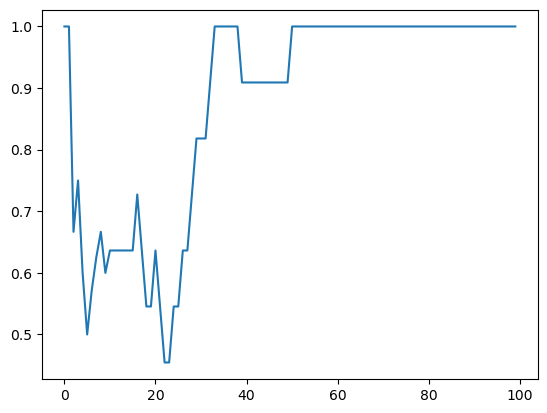

In [10]:
test_ECM = Priming_ECM(num_actions = 2, action_primes = [0., 1.5])
#Number of steps to run simulation
T = 100
data_log = [None] * T
env = RLGL() #create a default red-light-green-light environment

for t in range(T):
    observation = env.get_observation()
    action = test_ECM.sample(observation)
    reward = env.get_reward(action)
    test_ECM.learn(reward)
    data_log[t] = {"env_state": env.state, "action": action, "reward": reward}
    env.transition(action)

plt.plot(range(T), [np.mean([data_log[step]["reward"] for step in range(i-10,i+1) if step >= 0]) for i in range(T)]) #plot a 10 step moving average of the reward 

## Situated Projective Simulation

Situated Projective Simulation is a model of epsidic memory. The central goal of the model is to understand how the "clips" of an ECM become encoded, such that a graph structure supporting Projective Simulation emerges. A central hypothesis of the model is that agents use encodings of past events to perform **recursive state estimation** with a **Bayesian Filter**. The "actions" of a SiPS ECM are predictions - they may apply to sensory states or to active states of an agent, for example by treating some predictions as "action predictions", as with the priming ECM detailed above.

The following section develops the ECM of a Situated Projective Simulation agent in parts. Each part builds upon the last. First, the core mechanism of a recursive state estimation with a Bayesian filter is introduced. This ECM handles the case where a Hidden Markov Model of the environment is already known. Then, a simple "sequence filter" is introduced, which uses a remembered sequence of past percepts, rather than a known HMM, as the basis for recursive state estimation with the Bayesian Filter. Third, a "short-term episodic memory" is introduced, in which the memory of encoded percept sequences "fades" - allowing generalization of past sequences to new sequences based on similarity. Fourth, a "long-term episodic memory" is introduced, which inhibits the fading of memories as a function of surprise at time of encoding and the strengh of future re-activations. The predictions of such memories are also modified at moments of re-activation, allowing them to morph into more generalized, semantic knowledge of then envionment's properties.

### Update Functions for Bayesian Filters
Here, we collect functions for updating individual components of any Bayesian filter for recursive state estimation in an HMM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap

class Bayesian_Hypothesis_Filter():
    """
    A Bayesian_Hypothesis_Filter is a set of hypotheses where each hypothesis posits:
     (1) a probability for all states of K sensory categories with discrete state spaces and ...
     (2) a probability that each hypothesis will be true when the sensory category states are next updated. 
    The Bayesian_Hypothesis_Filter maintains a belief state over these hypotheses.
    It assumes the set of hypotheses are exhaustive and mutually exclusive. 
    
    The sample function takes the states of each category as input (percept), updates the belief state of the Bayesian_Hypothesis_Filter and ...
    returns: K probability distributions that predict the next state of each sensory category.
    """

    def __init__(
        self,
        category_sizes: list,                # number of states per sensory category
        sensory_predictions: np.ndarray,      # Each row represents an hypothesis, and the columns have groups of sizes given by category_sizes such that the sum of each group for each hypothesis is 1
        transition_predictions: np.ndarray,   # Each row represents an hypothesis: columns give the predicted probabilities under that hypothesis that each hypothesis will be true for the next percept. 
        belief_prior: np.ndarray = None,     # Optional initial belief prior. If none, set to uniform over hypotheses
        log_base = 2.,                       # Sets base to use for logarithms and exponential functions
        data_record: list = [],              # a list of internal variable names (e.g. likelihoods, belief_state) to record each time step. Accepts "all"
        record_until: int = -1               # number of time steps to record. default of -1 results no data recording.
    ):
        
        self.category_sizes = category_sizes
        self.category_indexer = np.repeat(np.arange(0, len(category_sizes)), category_sizes) #an array for labeling/slicing sensory hypotheses by category
        self.num_hypotheses = np.shape(sensory_predictions)[0]              
        self.transition_predictions = transition_predictions
        self.sensory_predictions = sensory_predictions
        self.log_base = log_base
        ##~~~~~~enforce structure
        if not sum(category_sizes) == np.shape(sensory_predictions)[1]:
            raise ValueError("sensory_predictions must have a number of columns equal to the total number of percept category states")
        
        
        #check for category sums of one, allowing for floating point precision
        for i in range(np.shape(sensory_predictions)[0]): #for each hypothesis
            for k in range(len(category_sizes)): #for each sensory category
                if not np.abs(np.sum(sensory_predictions[i,self.category_indexer == k])-1) < 1e-9:
                    raise ValueError("hypothesized probabilities for each sensory category must have a total probability of 1")

        if not np.shape(sensory_predictions)[0] == np.shape(transition_predictions)[0]:
            raise ValueError("sensory_predictions and transition_predictions must have the same number of columns")
        if not np.shape(transition_predictions)[0] == np.shape(transition_predictions)[1]:
            raise ValueError("transition_predictions must have the same number of columns and rows")
        ##~~~~~~


        # Initialize percept object and likelihoods of the percept for each hypothesis as empty arrays
        self.percept = np.empty(len(self.category_sizes), dtype = int)
        self.likelihoods = np.zeros(self.num_hypotheses)

        # Set the initial belief prior to uniform if none is provided
        if belief_prior is None:
            self.belief_prior = np.full(self.num_hypotheses, fill_value = 1/self.num_hypotheses)
        else:
            self.belief_prior = belief_prior

        # Compute initial sensory category predictions as a belief-prior-weighted sum over sensory hypotheses
        self.sensory_expectation = self.belief_prior @ self.sensory_predictions

        # Initialize object for belief posterior - values are placeholder to fullfull requirement that posteriors sums to one and are not used
        self.belief_posterior = np.full(self.num_hypotheses, fill_value = 1/self.num_hypotheses)

        self.prepare_data_storage(data_record, record_until) #for diagnostics
    
    def prepare_data_storage(self, data_record, record_until):
        '''sets up data recording structure for diagnostics and visualizing the filtering process'''
        
        self.data_dic = {"belief_prior": None, 
                     "likelihoods": None, 
                     "belief_posterior": None,
                     "sensory_expectation": None, 
                     "surprise": None}
        
        self.data_timer = 0
        self.record_until = record_until
        
        if "all" in data_record:
            if len(data_record) > 1:
                print("Warning, data_record contains 'all', additional entries will be ignored")
            data_record = self.data_dic.keys()

        if self.record_until < 0 and len(data_record) > 0:
            print("Warning, 'data_record' indicates data should be recorded but a positive value was not given for 'record_until'. No data will be recorded")

        #add empty data set for each variable in data_log
        for variable in data_record:
            if variable not in self.data_dic.keys():
                print("Warning, " + str(variable) + " in data_record not a valid variable name and will be ignored")
            elif variable in ["belief_prior", "likelihoods", "belief_posterior"]:
                self.data_dic[variable] = np.full((self.record_until, self.num_hypotheses), fill_value = -1., dtype = float) #fill value is outside allowable range for variables to indicate unfilled data
            elif variable == "sensory_expectation":
                self.data_dic[variable] = np.full((self.record_until, np.sum(self.category_sizes)), fill_value = -1., dtype = float) #fill value is outside allowable range for variables to indicate unfilled data
            elif variable == "surprise":
                self.data_dic[variable] = np.full((self.record_until, len(self.category_sizes)), fill_value = -1., dtype = float) #fill value is outside allowable range for variables to indicate unfilled data
            else:
                print("Warning, unexpected condition in data_record variables")        
        
    def sample(self, percept) -> np.ndarray:
        '''given a percept, updates network states and returns a vector of sensory expectations'''
        assert isinstance(percept, np.ndarray)
        assert np.issubdtype(percept.dtype, np.integer)
        #record belief prior
        if self.data_timer < self.record_until and self.data_dic["belief_prior"] is not None:
            self.data_dic["belief_prior"][self.data_timer,:] = self.belief_prior

        #update likelihoods and record
        self.update_likelihoods(percept)
        if self.data_timer < self.record_until and self.data_dic["likelihoods"] is not None:
            self.data_dic["likelihoods"][self.data_timer,:] = self.likelihoods

        #record surprise
        if self.data_timer < self.record_until and self.data_dic["surprise"] is not None:
            self.data_dic["surprise"][self.data_timer,:] = self.get_surprise()

        #update belief posterior and record
        self.update_belief_posterior()
        if self.data_timer < self.record_until and self.data_dic["belief_posterior"] is not None:
            self.data_dic["belief_posterior"][self.data_timer,:] = self.belief_posterior

        #predict
        self.update_priors()

        #Advance timer for data logging
        self.data_timer += 1
                                           
        return self.sensory_expectation

    def update_likelihoods(
        self,
        percept: np.ndarray  # a vector indicating the state of each sensory category
    ):
        """Updates the Bayesian Filter's percept object with the new input and updates the likelihood accordingly."""
        # Check input shape
        if percept.shape[0] != len(self.category_sizes):
            raise ValueError("Percept vector size does not match the number of perceptual categories.")
        for i in range(len(self.category_sizes)):
            if not percept[i] in range(self.category_sizes[i]):
                raise ValueError("The state of each percept category should be in {0,1,...,N_i - 1}, where N_i is the number of states for that percept category")
                #using 0 for first state helps with indexing memory array
        self.percept = percept

        # compute each likelihood as the product of each sensory_category's likelihood given the corresponding hypothesis,
        one_hot_percept = self.get_one_hot_percept() #function uses self.percept
        category_likelihoods = self.sensory_predictions[:,one_hot_percept] #gets the probability of each sensory category state under each hypothesis
        self.likelihoods = np.prod(category_likelihoods, axis=1) #likelihood of full percept given each hypothesis by taking product of values in each row

    def update_belief_posterior(self):
        """Sets belief_posterior based on likelihoods and belief prior."""
        # Compute the unnormalized activation (Bayesian inference numerator)
        numerator = self.likelihoods * self.belief_prior

        # Normalize to ensure it sums to one (Bayesian posterior)
        denominator = np.sum(numerator)

        if denominator != 0:
            self.belief_posterior = numerator / denominator
        else:
            # Avoid division by zero if all values are 0
            print("Warning: posterior probabilities sum to 0. This implies a bad model has been given and the agent believes it can not be in any known state. Problems will occur")
            self.belief_posterior = np.zeros(self.num_hypotheses)

    def update_priors(self):
        """Set belief_prior and sensory_expectation based on belief_posterior and transition_predictions."""
        #update belief_prior
        self.update_belief_prior()
        # Update sensory_expectation using a prior-belief-weighted sum of sensory hypotheses
        self.sensory_expectation = self.belief_prior @ self.sensory_predictions

    def update_belief_prior(self):
        row_sums = self.transition_predictions.sum(axis=1, keepdims=True)
        assert(row_sum == 1 for row_sum in row_sums)
        # Update belief prior using the transition hypotheses and belief posterior
        self.belief_prior = self.belief_posterior @ self.transition_predictions

    def get_surprise(self) -> float:
        """Compute the total surprise of the network."""
        # Compute the surprise of each element using the binary cross-entropy formula
        category_likelihoods = self.sensory_expectation[self.get_one_hot_percept()]
        mask = category_likelihoods == 0. #avoids log(0)
        surprise_values = np.full(category_likelihoods.shape, fill_value = -1.) #uses -1., outside range of allowable values, to indicate where log(0) would have been taken
        surprise_values[~mask] = -np.log(category_likelihoods[~mask])/np.log(self.log_base)

        # Return surprise for each percept category
        return surprise_values

    def get_one_hot_percept(self):
        one_hot_percept = np.zeros(np.sum(self.category_sizes), dtype=bool) 
        one_hot_percept[np.cumsum(self.category_sizes) - self.category_sizes + self.percept] = True #add category state to category start index.
        return one_hot_percept

#### Example

In this example, we set up an environment that alternates between flipping a pair of biased coins and a pair of fair coins. The Bayesian Network's memory gives it the probabilities of the coin flips in each state, and the Transition Array gives it the alternating state sequence pattern. The network does not know which state the system starts in, however. By recording and plotting the predictions the Bayesian Network, we can see how accumulating sensory evidence over times allows the Bayesian Network to establish which state the system is in and make accurate state-based predictions about the next flips.

In [12]:
#Set up Paramters 
T = 100
probabilities = np.array([[0.7,0.5],
                         [0.3,0.5],
                         [0.4,0.5],
                         [0.6,0.5]])
category_sizes = [2,2]
transition_matrix = np.array(([0,1],[1,0])) #state transition probabilities

#Create variable for storing prediction data and initialize bayesian network instance
predictions = np.zeros((np.shape(probabilities)[0],T)) #time steps by number of perceptual categories
test_bayesian_net = Bayesian_Network(memory = probabilities, transition_matrix = transition_matrix, category_sizes = category_sizes)

heads_probs_biased = probabilities[[0,2],0]
heads_probs_fair = probabilities[[0,2],1]
for t in range(T):
    if t % 2 == 0: #biased state first
        percept = np.random.binomial(n = 1, p = heads_probs_biased)
    else:          #fair state second
        percept = np.random.binomial(n = 1, p = heads_probs_fair) 

    predictions[:,t] = test_bayesian_net.sample(percept)

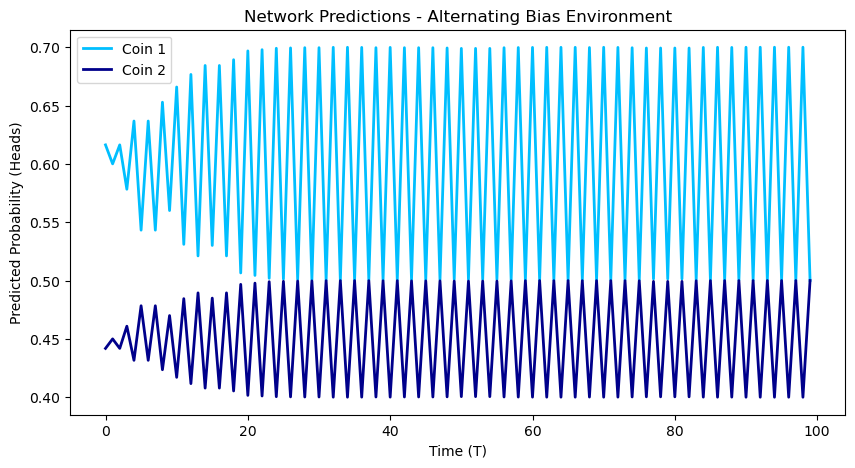

In [13]:
"""
Plot the predicted probabilities over time
"""
plt.figure(figsize=(10, 5))
plt.plot(range(T), [predictions[0,i] for i in range(T)], label='Coin 1', linewidth=2, color='deepskyblue') #plot expected probabilitiy of coin 1 heads
plt.plot(range(T), [predictions[2,i] for i in range(T)], label='Coin 2', linewidth=2, color='darkblue') #plot expected probabilitiy of coin 2 heads

plt.xlabel("Time (T)")
plt.ylabel("Predicted Probability (Heads)")
plt.title("Network Predictions - Alternating Bias Environment")
plt.legend(loc = 2)
plt.show()

### Bayesian Memory Network

### Example

In this example, set up a cyclical Hidden Markov Process in which a light turns green, turns off, turns blue, turns off, then turns green again and restarts. We show how to pass the percepts from this environment to the Memory Network, record the network's internal states over time, and visualize these states after simuluation.

In [15]:
from projective_simulation.environments import Cyclic_Env
from projective_simulation.methods.visualization import plot_heatmap

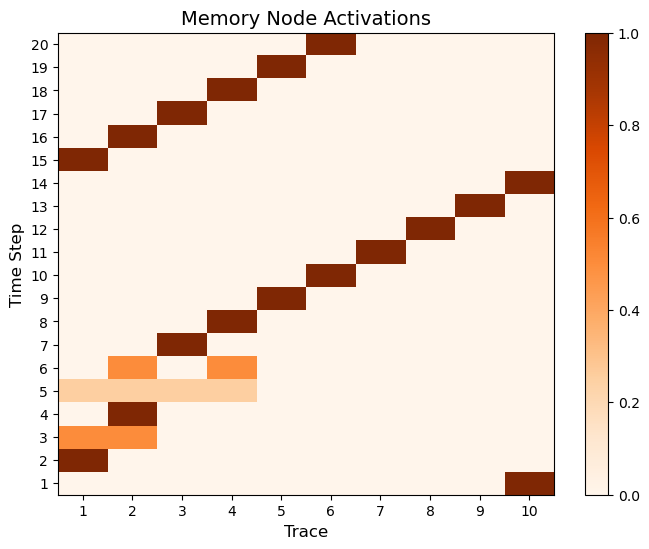

In [16]:
#define percepts
off = 0
green = 1
blue = 2
colormap = np.array(['lightgrey', 'green', 'blue']) #for plotting

#define environment
percept_cycle = np.array([green,off,blue,off]) #light off, light green, light off, light blue
simple_light_cycle = Cyclic_Env(percept_cycle)


#define agent
num_m_nodes = 10
category_sizes = [3]
test_bayesian_memory = Bayesian_Memory(category_sizes = category_sizes, 
                                       num_m_nodes = num_m_nodes
                                      )

#prepare simulation
T = 20 #total time to run simulation
test_bayesian_memory.prepare_data_storage(data_record = ["all"], record_until = T)

#simulate
for t in range(T):
    percept = simple_light_cycle.get_observation()
    test_bayesian_memory.sample(percept)
    simple_light_cycle.transition()

#plot memory trace activations over time
plot_heatmap(test_bayesian_memory.data_dic["m_activation"], title = "Memory Node Activations", color = "Oranges")

## Forgetful Memory Network

### Example

In [18]:
#define percepts
off = 0
green = 1
blue = 2
colormap = np.array(['lightgrey', 'green', 'blue']) #for plotting

#define environment
percept_cycle = np.array([green,off,blue,off]) #light off, light green, light off, light blue
simple_light_cycle = Cyclic_Env(percept_cycle)


#define agent
num_m_nodes = 10
category_sizes = [3]
test_forgetful_memory = Forgetful_Memory(category_sizes = category_sizes, 
                                         num_m_nodes = num_m_nodes,
                                         forgetting_rate = 0.01,
                                         belief_uncertainty = 0.00001
                                      )

#prepare simulation
T = 10 #total time to run simulation
test_forgetful_memory.prepare_data_storage(data_record = ["all"], record_until = T)

#simulate
for t in range(T):
    percept = simple_light_cycle.get_observation()
    test_forgetful_memory.sample(percept)
    simple_light_cycle.transition()

#plot memory trace activations over time
plot_heatmap(test_forgetful_memory.data_dic["m_activation"], title = "Memory Node Activations", color = "Oranges")

ValueError: All rows in pmfs must sum to one

In [ ]:
test_forgetful_memory.memory

## Example

In [ ]:
#define percepts
off = 0
green = 1
blue = 2
colormap = np.array(['lightgrey', 'green', 'blue']) #for plotting

#define environment
percept_cycle = np.array([green,off,blue,off]) #light off, light green, light off, light blue
simple_light_cycle = Cyclic_Env(percept_cycle)


#define agent
num_m_nodes = 10
category_sizes = [3]
test_selective_memory = Selectively_Forgetful_Memory(category_sizes = category_sizes, 
                                                     num_m_nodes = num_m_nodes,
                                                     forgetting_rate = 0.01,
                                                     belief_uncertainty = 0.00001
                                                    )

#prepare simulation
T = 10 #total time to run simulation
test_selective_memory.prepare_data_storage(data_record = ["all"], record_until = T)

#simulate
for t in range(T):
    percept = simple_light_cycle.get_observation()
    test_selective_memory.sample(percept)
    simple_light_cycle.transition()

#plot memory trace activations over time
plot_heatmap(test_selective_memory.data_dic["m_activation"], title = "Memory Node Activations", color = "Oranges")

## Hierachcical Bayes

In [20]:
import numpy as np
from itertools import product
from typing import Sequence, Optional, List, Tuple

class Hierarchical_Bayes_Filter(Abstract_ECM):
    """
    Hierarchical Bayes filter that instantiates the Eq. (6) construction:
      • For every supported environment size n with p(N=n) > 0 and every sequence s^(1:n) ∈ S^n,
        create a disjoint hypothetical HMM with n latent states in a deterministic cycle and
        deterministic observations p(s_k | x_k) = 1.
      • The global latent space is the disjoint union of all such HMMs.
      • The initial belief mixes partitions by their prior p(N=n) times the i.i.d. sensory-bias
        sequence probability; within each partition all mass is on its first state.

    Internally:
      • next_state : (N_latent,) int — deterministic transition mapping for each latent state
      • emit_symbol: (N_latent,) int — which sensory symbol is emitted deterministically
      • belief_state: (N_latent,) float — predictive belief p(x_t | s_{1:t-1})
    """

    def __init__(self,
                 sensory_size: int,                                  # |S|: number of sensory categories
                 sensory_bias: Sequence[float],                      # length-|S| pmf over sensory symbols (implicit bias), sums to 1
                 env_sizes: Sequence[int],                           # supported environment sizes (e.g., [1,2,3])
                 env_size_probs: Sequence[float],                    # pmf over env_sizes, same length, sums to 1
                 dtype: type = np.float64                            # numeric dtype
                 ):
        super().__init__()

        # ---------------------- Validate + coerce inputs ----------------------
        self.S: int = int(sensory_size)
        self.pi_s: np.ndarray = np.asarray(sensory_bias, dtype=dtype).reshape(-1)
        assert self.pi_s.shape == (self.S,), "sensory_bias must have length == sensory_size"
        self.pi_s = self._normalize(self.pi_s)

        self.env_sizes: np.ndarray = np.asarray(env_sizes, dtype=int).reshape(-1)
        self.p_env: np.ndarray = np.asarray(env_size_probs, dtype=dtype).reshape(-1)
        assert self.env_sizes.ndim == 1 and self.p_env.ndim == 1, "env_sizes/env_size_probs must be 1D"
        assert self.env_sizes.size == self.p_env.size, "env_sizes and env_size_probs must match in length"
        assert np.all(self.env_sizes >= 1), "Environment sizes must be >= 1"
        self.p_env = self._normalize(self.p_env)
        self.dtype = dtype

        # ---------------------- Plan sizes; guard against blow-up ----------------------
        # Number of partitions for a given n is S**n; total latent states sum_n n * S**n.
        try:
            part_counts = [self.S ** int(n) for n in self.env_sizes.tolist()]
        except OverflowError:
            raise ValueError("S ** n overflowed. Reduce S or n.")
        total_partitions = int(sum(part_counts))
        total_states = int(sum(int(n) * (self.S ** int(n)) for n in self.env_sizes.tolist()))

        # Light sanity cap to avoid accidental combinatorial explosions.
        # Adjust or remove if you know your sizes are manageable.
        MAX_LATENT = 250_000
        if total_states > MAX_LATENT:
            raise ValueError(
                f"Requested construction yields {total_states} latent states, which exceeds the "
                f"safe cap ({MAX_LATENT}). Reduce env_sizes and/or S, or add a custom generator."
            )

        # ---------------------- Allocate global structures ----------------------
        self.N_latent: int = total_states
        self.next_state: np.ndarray = np.empty(self.N_latent, dtype=np.int64)  # src -> dst
        self.emit_symbol: np.ndarray = np.empty(self.N_latent, dtype=np.int64) # deterministic emission
        self.belief_state: np.ndarray = np.zeros(self.N_latent, dtype=dtype)   # predictive prior

        # For reset: remember each partition's first-state index and its (unnormalized) weight
        first_state_indices: List[int] = []
        partition_weights_unnorm: List[float] = []

        # Optional: metadata slices (start, stop) per partition; can be handy for inspection
        self.partition_slices: List[Tuple[int, int]] = []

        # ---------------------- Build partitions per Eq. (6) ----------------------
        cursor = 0  # running index into the concatenated latent state vector
        for n_idx, n in enumerate(self.env_sizes.tolist()):
            pn = float(self.p_env[n_idx])  # p(N=n)
            # Enumerate all sequences s^(1:n) ∈ S^n
            for seq in product(range(self.S), repeat=int(n)):
                start = cursor
                stop = start + int(n)
                # Deterministic observation: state k emits seq[k]
                for k in range(int(n)):
                    idx = start + k
                    self.emit_symbol[idx] = int(seq[k])
                    # Deterministic cycle transition
                    self.next_state[idx] = start + ((k + 1) % int(n))
                # Prior weight for this partition: p(N=n) * prod_k pi_s[seq[k]]
                seq_prob = 1.0
                for sym in seq:
                    seq_prob *= float(self.pi_s[int(sym)])
                w = pn * seq_prob

                # Initial prior: conditional on partition -> all mass on first state
                first_state_indices.append(start)
                partition_weights_unnorm.append(w)

                # Record slice and advance
                self.partition_slices.append((start, stop))
                cursor = stop

        assert cursor == self.N_latent, "Internal size accounting error."

        # ---------------------- Initialize belief (mixture over partitions) ----------------------
        Z = float(np.sum(partition_weights_unnorm))
        if Z == 0.0 or not np.isfinite(Z):
            # Degenerate case (e.g., sensory_bias had zeros everywhere): fall back to uniform over partitions
            norm_weights = np.ones(len(partition_weights_unnorm), dtype=self.dtype) / max(1, len(partition_weights_unnorm))
        else:
            norm_weights = np.asarray(partition_weights_unnorm, dtype=self.dtype) / Z

        for idx, w in zip(first_state_indices, norm_weights.tolist()):
            self.belief_state[idx] += w

        # Keep for resets
        self._first_state_indices = np.asarray(first_state_indices, dtype=np.int64)
        self._partition_weights_norm = np.asarray(norm_weights, dtype=self.dtype)

        # Bookkeeping for last update
        self._last_posterior: Optional[np.ndarray] = None
        self._last_observation: Optional[int] = None

    # -------------------------------------------------------------------------
    # Core update: deterministic likelihood + deterministic transition
    # -------------------------------------------------------------------------
    def sample(self,
               sensory_state: int  # observed sensory symbol index at time t, in [0, S-1]
               ) -> np.ndarray:
        """
        Consume an observation s_t, perform Bayes update, predict one step ahead, and
        return the *prior over sensory* at t+1, i.e. p(s_{t+1} | s_{1:t}).

        Returns
        -------
        p_next_sensory : (S,) ndarray
            Distribution over sensory symbols for the next time step.
        """
        s = int(sensory_state)
        if not (0 <= s < self.S):
            raise ValueError(f"sensory_state must be in [0, {self.S-1}]")

        # Likelihood is 1 for states whose deterministic emission == s, else 0
        mask = (self.emit_symbol == s)
        posterior_unnorm = self.belief_state * mask.astype(self.belief_state.dtype)
        total = posterior_unnorm.sum()

        if not np.isfinite(total) or total <= 0:
            # Incompatible evidence under current predictive belief: reset support to all states emitting s
            # and renormalize uniformly on that support (conservative, avoids NaNs).
            support = np.where(mask)[0]
            if support.size == 0:
                # Should never happen given construction, but guard anyway
                posterior = np.ones_like(self.belief_state) / self.N_latent
            else:
                posterior = np.zeros_like(self.belief_state)
                posterior[support] = 1.0 / support.size
        else:
            posterior = posterior_unnorm / total

        # Deterministic time prediction: shove probability mass along next_state permutation
        predictive_next = np.zeros_like(self.belief_state)
        predictive_next[self.next_state] = posterior  # permutation write

        # Prior over s_{t+1}: sum predictive mass by emitted symbol
        p_next_sensory = np.bincount(self.emit_symbol, weights=predictive_next, minlength=self.S).astype(self.dtype)
        p_next_sensory = self._normalize(p_next_sensory)

        # Advance internal predictive belief and cache posterior
        self._last_posterior = posterior
        self._last_observation = s
        self.belief_state = predictive_next

        return p_next_sensory

    # -------------------------------------------------------------------------
    # Convenience / inspection
    # -------------------------------------------------------------------------
    def reset_belief(self):
        """Reset to the construction-time hierarchical prior (all mass on each partition's first state, mixed by its prior)."""
        self.belief_state.fill(0.0)
        for idx, w in zip(self._first_state_indices.tolist(), self._partition_weights_norm.tolist()):
            self.belief_state[int(idx)] += float(w)
        self._last_posterior = None
        self._last_observation = None

    def current_posterior(self) -> Optional[np.ndarray]:
        """Return p(x_t | s_{1:t}) from the most recent update (None if sample() not yet called)."""
        return None if self._last_posterior is None else self._last_posterior.copy()

    def dense_T(self) -> np.ndarray:
        """Materialize the deterministic transition matrix T (N×N), where T[i, j]=1 iff j = next_state[i]."""
        T = np.zeros((self.N_latent, self.N_latent), dtype=self.dtype)
        T[np.arange(self.N_latent, dtype=np.int64), self.next_state] = 1.0
        return T

    def dense_O(self) -> np.ndarray:
        """Materialize the deterministic observation matrix O (N×S), where O[i, s]=1 iff s == emit_symbol[i]."""
        O = np.zeros((self.N_latent, self.S), dtype=self.dtype)
        O[np.arange(self.N_latent, dtype=np.int64), self.emit_symbol] = 1.0
        return O

    # -------------------------------------------------------------------------
    # Utilities
    # -------------------------------------------------------------------------
    @staticmethod
    def _normalize(x: np.ndarray) -> np.ndarray:
        s = float(np.sum(x))
        if not np.isfinite(s) or s <= 0:
            return np.ones_like(x) / max(1, x.size)
        return x / s

In [21]:
# Tiny example: S=3, env sizes {2,3}
S = 3
pi = [0.6, 0.3, 0.1]
env_sizes = [2, 3]
p_env = [0.7, 0.3]
h = Hierarchical_Bayes_Filter(S, pi, env_sizes, p_env)

# Observe symbol 0 twice
print("N_latent =", h.N_latent)
p_next = h.sample(0)
print("p(s_{t+1}|obs=[0]) =", np.round(p_next, 4))
p_next = h.sample(0)
print("p(s_{t+1}|obs=[0,0]) =", np.round(p_next, 4))

N_latent = 99
p(s_{t+1}|obs=[0]) = [0.6 0.3 0.1]
p(s_{t+1}|obs=[0,0]) = [0.88 0.09 0.03]


#| hide
# nbdev export

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()